This is Igor's Notebook and here we will explore how LSTM can predict the performance of bitcoin!

In [3]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

2025-04-20 19:42:31.969398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 19:42:32.365073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 19:42:32.643498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745192552.898971 1569704 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745192552.965537 1569704 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745192553.594862 1569704 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [8]:
import yfinance as yf

# Download Bitcoin historical data
btc_df = yf.download("BTC-USD", start="2021-04-10", end="2025-04-10")

# Save to CSV if needed
btc_df.to_csv("BTC-USD.csv")

btc_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-04-10  59793.234375  61276.664062  58038.707031  58253.777344   
2021-04-11  60204.964844  60790.554688  59289.796875  59846.230469   
2021-04-12  59893.453125  61253.035156  59589.875000  60175.945312   
2021-04-13  63503.457031  63742.285156  59869.957031  59890.019531   
2021-04-14  63109.695312  64863.097656  61554.796875  63523.753906   

Price            Volume  
Ticker          BTC-USD  
Date                     
2021-04-10  58238470525  
2021-04-11  46280252580  
2021-04-12  51828688519  
2021-04-13  69983454362  
2021-04-14  77451779687

In [30]:
import pandas as pd

# Load CSV and drop second and third rows (indexes 1 and 2)
df = pd.read_csv("BTC-USD.csv")
df = df.drop(index=[0,1]).reset_index(drop=True)

# Rename the "Price" column to "Date"
df = df.rename(columns={"Price": "Date"})


# Preview
df.head()



Date           Close            High             Low            Open  \
0  2021-04-10    59793.234375   61276.6640625  58038.70703125  58253.77734375   
1  2021-04-11  60204.96484375   60790.5546875    59289.796875  59846.23046875   
2  2021-04-12    59893.453125  61253.03515625       59589.875   60175.9453125   
3  2021-04-13  63503.45703125  63742.28515625  59869.95703125  59890.01953125   
4  2021-04-14   63109.6953125  64863.09765625    61554.796875  63523.75390625   

        Volume  
0  58238470525  
1  46280252580  
2  51828688519  
3  69983454362  
4  77451779687

In [31]:
df.shape

(1461, 6)

In [33]:
df.describe()

Date         Close           High            Low  \
count         1461          1461           1461           1461   
unique        1461          1461           1461           1460   
top     2021-04-10  59793.234375  61276.6640625  27375.6015625   
freq             1             1              1              2   

                  Open       Volume  
count             1461         1461  
unique            1461         1461  
top     58253.77734375  58238470525  
freq                 1            1

In [36]:
#checking for null
print('Null Values:',df.isnull().values.sum())

Null Values: 0


In [37]:
# Printing the start date and End date of the dataset

sd=df.iloc[0][0]
ed=df.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2021-04-10
Ending Date 2025-04-09


/tmp/ipykernel_1569704/661609988.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd=df.iloc[0][0]
/tmp/ipykernel_1569704/661609988.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ed=df.iloc[-1][0]


In [38]:
# Convert Date column to datetime format (if not already done)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Filter for your specific date range
df_filtered = df.loc[(df['Date'] >= '2021-04-10') & (df['Date'] <= '2025-04-09')]

# Drop the Volume column
df_filtered = df_filtered.drop(columns=['Volume'])


In [39]:
df_filtered

Date           Close            High             Low  \
0    2021-04-10    59793.234375   61276.6640625  58038.70703125   
1    2021-04-11  60204.96484375   60790.5546875    59289.796875   
2    2021-04-12    59893.453125  61253.03515625       59589.875   
3    2021-04-13  63503.45703125  63742.28515625  59869.95703125   
4    2021-04-14   63109.6953125  64863.09765625    61554.796875   
...         ...             ...             ...             ...   
1456 2025-04-05    83504.796875    84207.015625    82377.734375   
1457 2025-04-06    78214.484375     83704.71875   77097.7421875   
1458 2025-04-07   79235.3359375      81119.0625   74436.6796875   
1459 2025-04-08    76271.953125    80823.890625   76198.0234375   
1460 2025-04-09    82573.953125         83541.0    74589.671875   

                Open  
0     58253.77734375  
1     59846.23046875  
2      60175.9453125  
3     59890.01953125  
4     63523.75390625  
...              ...  
1456    83844.703125  
1457   83504.5078125  
1458   78221.3359375  
1459   79218.4765625  
1460      76273.5625  

[1461 rows x 5 columns]

In [46]:
# Convert Open and Close columns to numeric (if not already)
price_cols = ['Open', 'Close', 'High', 'Low']
df_filtered[price_cols] = df_filtered[price_cols].apply(pd.to_numeric, errors='coerce')

# Group by month name and compute average
monthwise = df_filtered.groupby(df_filtered['Date'].dt.strftime('%B'))[['Open', 'Close']].mean()

# Reorder months in calendar order
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 
             'July', 'August', 'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)

# Display result
monthwise


Open         Close
Date                                 
January    51007.416362  51069.400013
February   52235.447300  52286.940646
March      54835.659605  54965.389444
April      50242.491130  50092.926546
May        42903.368747  42728.754080
June       38603.518636  38472.876090
July       37123.869487  37211.559917
August     39012.909920  38962.319856
September  38086.918441  38102.300749
October    42958.637648  43223.913952
November   50189.221126  50347.293945
December   51845.659384  51748.165023

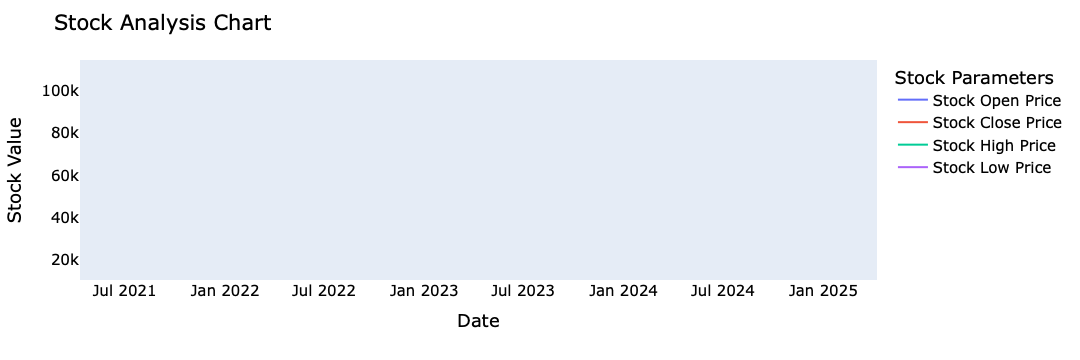

In [47]:
from itertools import cycle
import plotly.express as px

# Cycle through legend names
names = cycle(['Stock Open Price', 'Stock Close Price', 'Stock High Price', 'Stock Low Price'])

# Plot using column names (strings), not Series
fig = px.line(df_filtered, 
              x='Date', 
              y=['Open', 'Close', 'High', 'Low'],  # <-- correct form
              labels={'Date': 'Date', 'value': 'Stock Value'})

# Update layout
fig.update_layout(title_text='Stock Analysis Chart',
                  font_size=15,
                  font_color='black',
                  legend_title_text='Stock Parameters')

# Rename legend entries
fig.for_each_trace(lambda t: t.update(name=next(names)))

# Remove gridlines
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show plot
fig.show()


# Single Variable LSTM

### Extract and plot the Close price

Shape of close dataframe: (1461, 2)


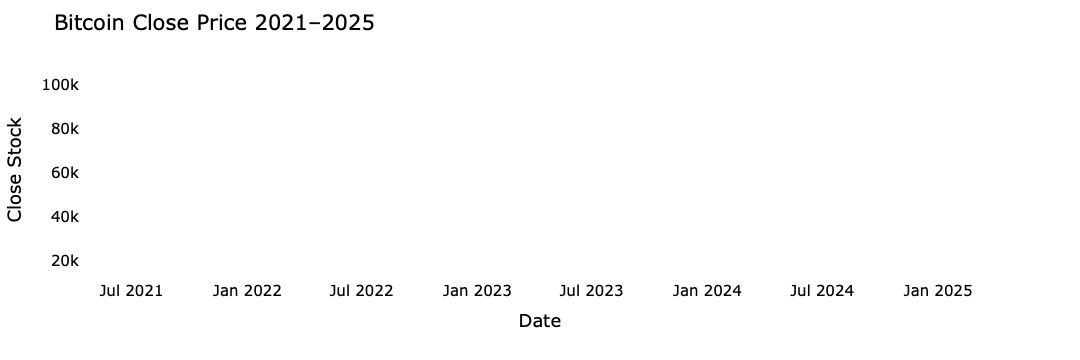

In [48]:
import plotly.express as px

# Take only Date and Close columns
closedf = df_filtered[['Date', 'Close']]
print("Shape of close dataframe:", closedf.shape)

# Plot full period
fig = px.line(closedf, x='Date', y='Close', labels={'Date': 'Date', 'Close': 'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Bitcoin Close Price 2021–2025', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


### Select recent data for modeling

Total data for prediction:  365


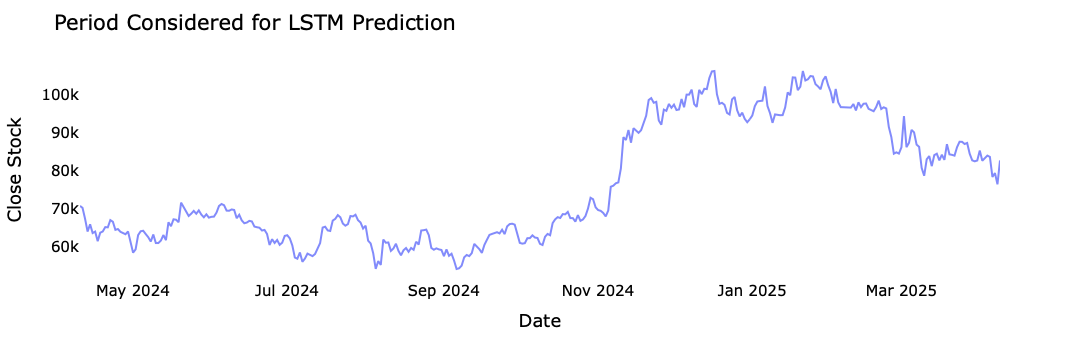

In [49]:
# Use the last ~1 year of data
closedf = closedf[closedf['Date'] > '2024-04-09']
close_stock = closedf.copy()
print("Total data for prediction: ", closedf.shape[0])

# Plot selected data
fig = px.line(closedf, x='Date', y='Close', labels={'Date': 'Date', 'Close': 'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Period Considered for LSTM Prediction', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


### Normalize Close price

In [50]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Drop Date column
closedf = closedf.drop(columns=['Date'])

# Normalize Close price
scaler = MinMaxScaler(feature_range=(0,1))
closedf = scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)


(365, 1)


### Split into train/test sets

In [51]:
# 60% train, 40% test
training_size = int(len(closedf) * 0.60)
test_size = len(closedf) - training_size

train_data = closedf[0:training_size]
test_data = closedf[training_size:]
print("train_data:", train_data.shape)
print("test_data:", test_data.shape)


train_data: (219, 1)
test_data: (146, 1)


### Time Series dataset creation function

In [65]:
# Helper to create sequences for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step and create sequences
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (203, 15)
y_train: (203,)
X_test: (130, 15)
y_test: (130,)


### Reshape for LSTM

In [66]:
# Reshape into [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (203, 15, 1)
X_test: (130, 15, 1)


 ## Build & Train the LSTM Model

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(LSTM(units=50, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile
model.compile(loss="mean_squared_error", optimizer="adam")

# Callback to stop early if val_loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=200, 
                    batch_size=32, 
                    verbose=1,
                    callbacks=[early_stop])


Epoch 1/200


/home/araujoig/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0425 - val_loss: 0.3643
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0226 - val_loss: 0.2080
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0116 - val_loss: 0.0785
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0077 - val_loss: 0.0409
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0067 - val_loss: 0.0659
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0051 - val_loss: 0.0672
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0057 - val_loss: 0.0444
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0039 - val_loss: 0.0264
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0047 - val_loss: 0.0148
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0031 - val_loss: 0.0068
E

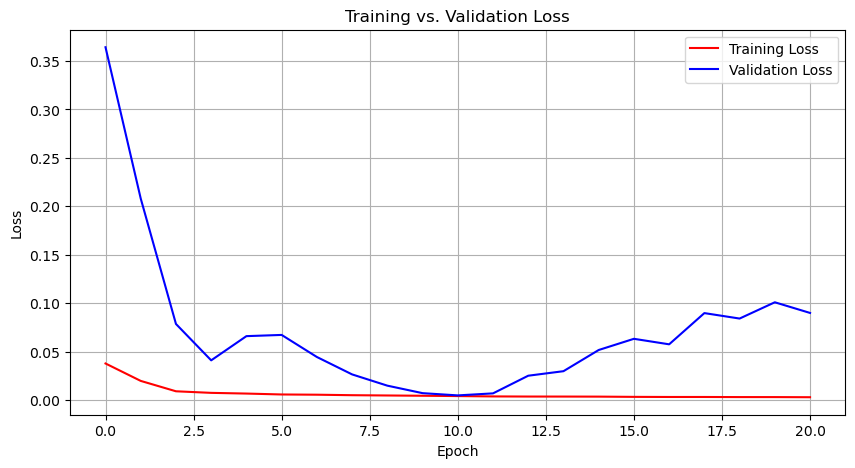

In [68]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math

# Training set metrics
print("Train RMSE:", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train MSE:", mean_squared_error(original_ytrain, train_predict))
print("Train MAE:", mean_absolute_error(original_ytrain, train_predict))
print("Train Explained Variance Score:", explained_variance_score(original_ytrain, train_predict))
print("Train R2 Score:", r2_score(original_ytrain, train_predict))

print("----------------------------------------------------")

# Test set metrics
print("Test RMSE:", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test MSE:", mean_squared_error(original_ytest, test_predict))
print("Test MAE:", mean_absolute_error(original_ytest, test_predict))
print("Test Explained Variance Score:", explained_variance_score(original_ytest, test_predict))
print("Test R2 Score:", r2_score(original_ytest, test_predict))


Train RMSE: 3191.74779147693
Train MSE: 10187253.964397863
Train MAE: 2321.21116841133
Train Explained Variance Score: 0.6746854003896958
Train R2 Score: 0.6718186878010175
----------------------------------------------------
Test RMSE: 3580.68059701608
Test MSE: 12821273.53784743
Test MAE: 2877.339543269231
Test Explained Variance Score: 0.7941308230307205
Test R2 Score: 0.7682307784038427


# Multivariate LSTM model
### We will use now more features to help the model learn better context: Open, High, Low, Close

In [72]:
# Use multivariate features
features = ['Open', 'High', 'Low', 'Close']
df_multi = df_filtered[['Date'] + features].copy()

# Convert features to numeric just in case
df_multi[features] = df_multi[features].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaNs
df_multi.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_multi[features])

# Convert to DataFrame to preserve structure
scaled_df = pd.DataFrame(scaled, columns=features)
scaled_df['Date'] = df_multi['Date'].values


### Create Time Series Sequences

In [73]:
def create_multivariate_dataset(data, time_step=15):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :])
        y.append(data[i+time_step, 3])  # Index 3 = 'Close'
    return np.array(X), np.array(y)

time_step = 15
X, y = create_multivariate_dataset(scaled_df[features].values, time_step)

# Split
train_size = int(len(X) * 0.6)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (867, 15, 4)
X_test: (579, 15, 4)


### New model architecture

In [74]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Optional early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stop])


Epoch 1/200


/home/araujoig/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0231 - val_loss: 0.0182
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4345e-04 - val_loss: 0.0042
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5057e-04 - val_loss: 0.0057
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4054e-04 - val_loss: 0.0034
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.7392e-04 - val_loss: 0.0024
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.2667e-04 - val_loss: 0.0021
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4371e-04 - val_loss: 0.0018
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.2780e-04 - val_loss: 0.0014
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4704e-04 - val_loss: 0.0020
Epoch 12/200
28/28 ━━━━━━━━━━━━━

 ### Plot Losses

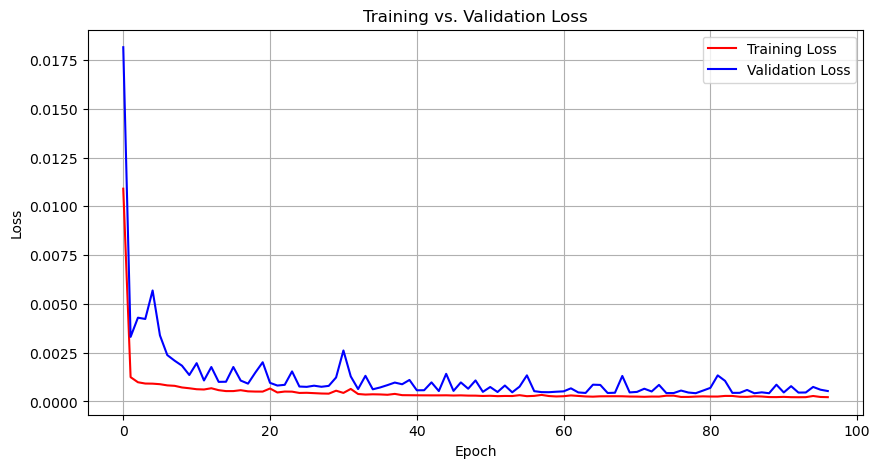

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Predictions and Inverse Scaling

In [78]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate([
    np.zeros((len(train_predict), 3)),  # Open, High, Low placeholders
    train_predict                       # Predicted Close
], axis=1))[:, 3]  # Extract only the Close column after inverse

test_predict = scaler.inverse_transform(np.concatenate([
    np.zeros((len(test_predict), 3)),
    test_predict
], axis=1))[:, 3]

# Inverse transform actuals
original_ytrain = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_train), 3)),
    y_train.reshape(-1, 1)
], axis=1))[:, 3]

original_ytest = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test), 3)),
    y_test.reshape(-1, 1)
], axis=1))[:, 3]


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### Evaluation

In [79]:
print("Train RMSE:", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train MSE:", mean_squared_error(original_ytrain, train_predict))
print("Train MAE:", mean_absolute_error(original_ytrain, train_predict))
print("Train Explained Variance:", explained_variance_score(original_ytrain, train_predict))
print("Train R2 Score:", r2_score(original_ytrain, train_predict))
print("----------------------------------------------------")
print("Test RMSE:", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test MSE:", mean_squared_error(original_ytest, test_predict))
print("Test MAE:", mean_absolute_error(original_ytest, test_predict))
print("Test Explained Variance:", explained_variance_score(original_ytest, test_predict))
print("Test R2 Score:", r2_score(original_ytest, test_predict))


Train RMSE: 1384.1965060024231
Train MSE: 1915999.967229316
Train MAE: 963.4032399910249
Train Explained Variance: 0.9886746136644643
Train R2 Score: 0.9876174100470239
----------------------------------------------------
Test RMSE: 1850.833053179279
Test MSE: 3425582.9907409316
Test MAE: 1300.4772963032326
Test Explained Variance: 0.9926586784318634
Test R2 Score: 0.9926567938546904


### Plot Actual vs Predicted

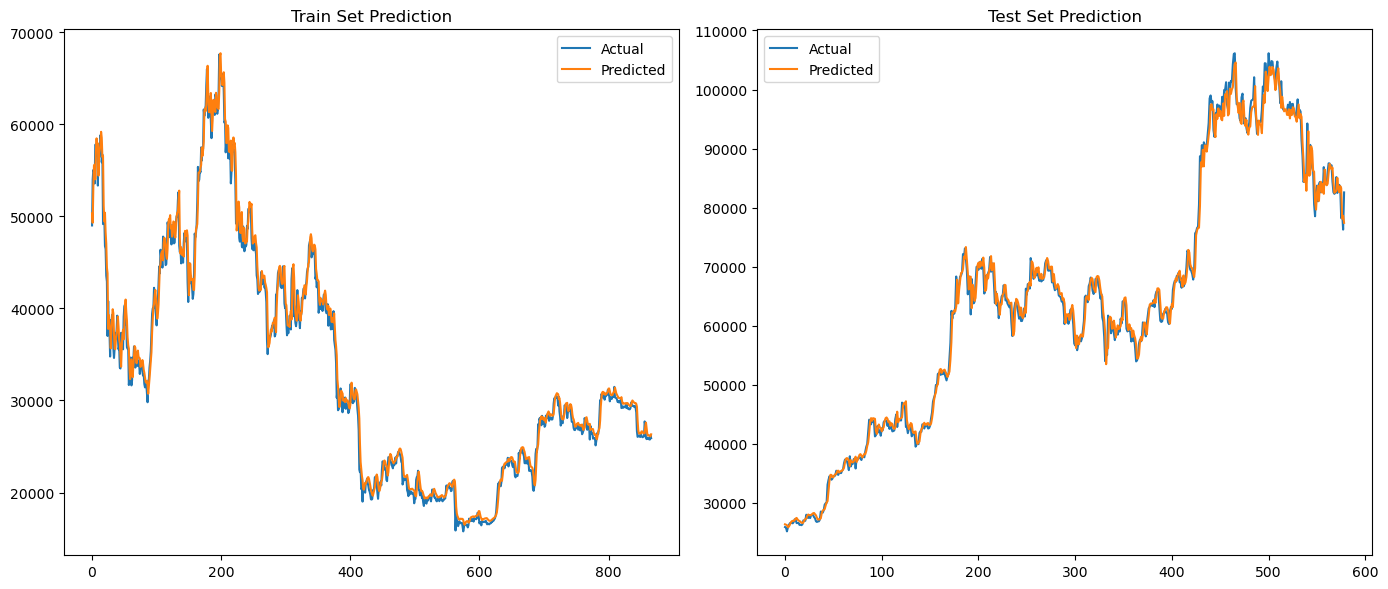

In [80]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(original_ytrain, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Train Set Prediction')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(original_ytest, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Test Set Prediction')
plt.legend()

plt.tight_layout()
plt.show()


### Actual vs Predicted – Time Series Overlay

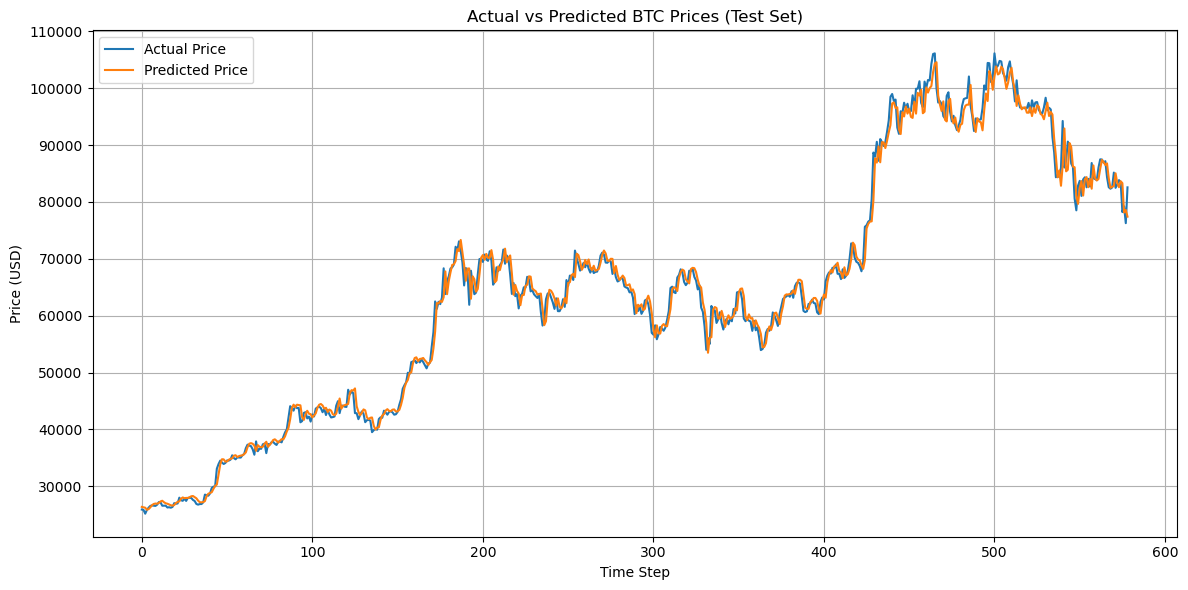

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(original_ytest, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title("Actual vs Predicted BTC Prices (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Prediction Error (Residuals Plot)

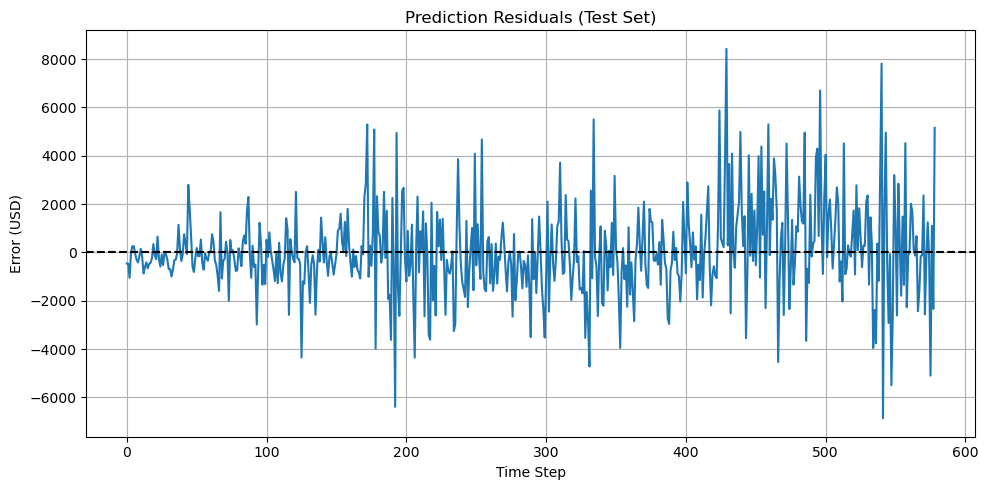

In [82]:
errors = original_ytest - test_predict
plt.figure(figsize=(10, 5))
plt.plot(errors)
plt.title("Prediction Residuals (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Error (USD)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


### Distribution of Prediction Errors

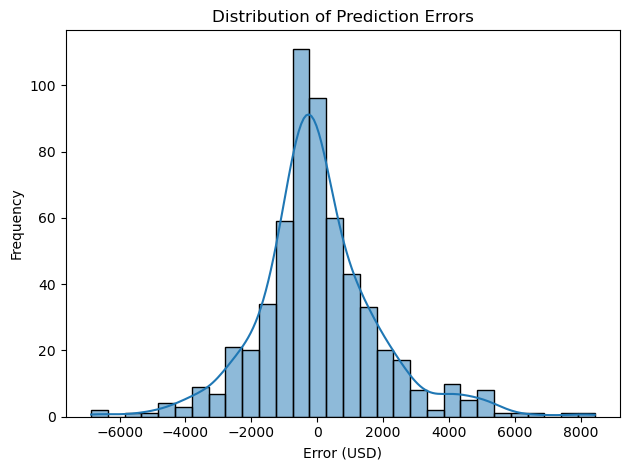

In [84]:
import seaborn as sns
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Moving Average + LSTM Prediction Overlay

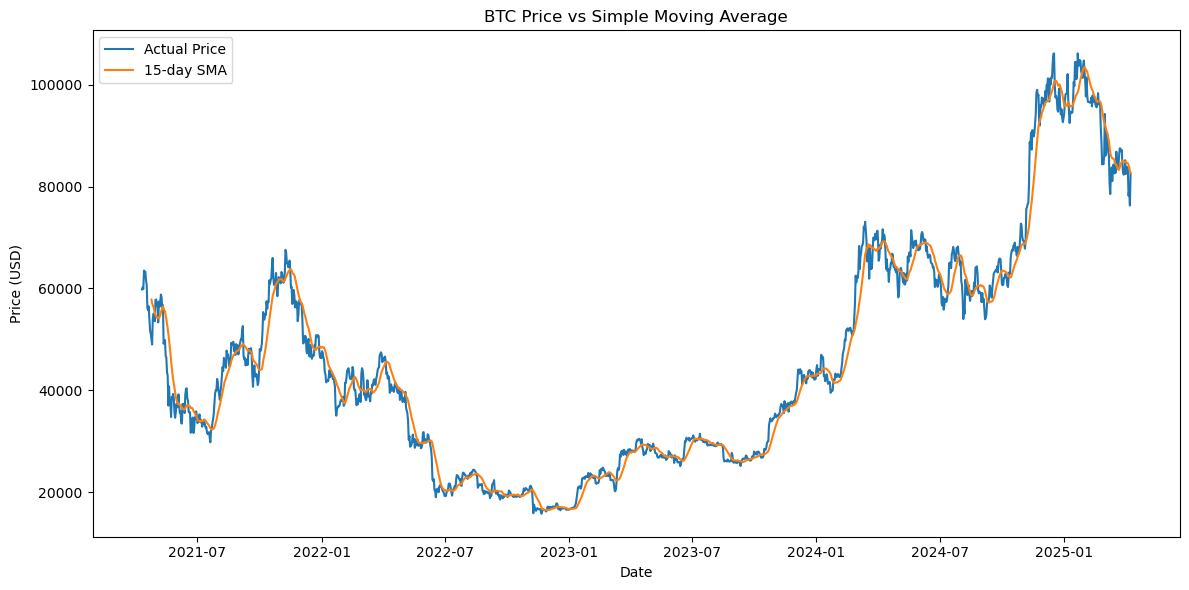

In [86]:
sma15 = df_filtered['Close'].rolling(15).mean()

plt.figure(figsize=(12,6))
plt.plot(df_filtered['Date'], df_filtered['Close'], label='Actual Price')
plt.plot(df_filtered['Date'], sma15, label='15-day SMA')
plt.title("BTC Price vs Simple Moving Average")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()
